In [1]:
"""
Plot results.

Author: Spencer M. Richards
        Autonomous Systems Lab (ASL), Stanford
        (GitHub: spenrich)
"""
import os

import dill

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

import numpy as np

import scipy

import jax

# Configure JAX before importing anything that uses JAX
jax.config.update('jax_platform_name', 'cpu')
jax.config.update('jax_enable_x64', True)

# Create directory for saving figures
directory = 'figures'
os.makedirs(directory, exist_ok=True)

# Plot customization
plt.rcParams.update({
    'font.family':       'serif',
    'font.serif':        ['Times New Roman', 'CMU Serif'],
    'mathtext.fontset':  'cm',
    'font.size':         24,
    'legend.fontsize':   'medium',
    'axes.titlesize':    'large',
    'lines.linewidth':   2,
    'lines.markersize':  10,
    'figure.dpi':        100,
    'savefig.dpi':       200,
    'savefig.format':    'png',
})
alpha = 0.2

systems = ['PlanarSpacecraft', 'PlanarBirotor']
titles = ['Spacecraft', 'PVTOL']

controllers = ['LQR', 'CCM', 'SDC', 'LQR (actual)', 'LQR (SDC dynamics)']
labels = ['LQR', 'CCM', 'SD-LQR (ours)', 'LQR (known dynamics)', 
          'LQR (our learned dynamics)']
zorders = [2, 1, 4, 0, 3]

fill_whiskers = False
log_scale = True

filename_template_unif = 'seed={}_N={}.dill'
filename_template_traj = 'seed={}_N={}_traj.dill'

seeds = list(range(5))
Ns_unif = [50, 100, 200, 500, 1000]
Ns_traj = [1, 2, 5, 10, 20, 50, 100]

colors = plt.get_cmap('tab10').colors[:len(zorders)]
patches = [Patch(label=l, color=c) for l, c in zip(labels, colors)]
legend_kwargs = {
    'handles':          patches,
    'loc':              'lower center', 
    'ncol':             len(labels), 
    'bbox_to_anchor':   (0.5, 0.),
}
ref_width, ref_height = 13, 8

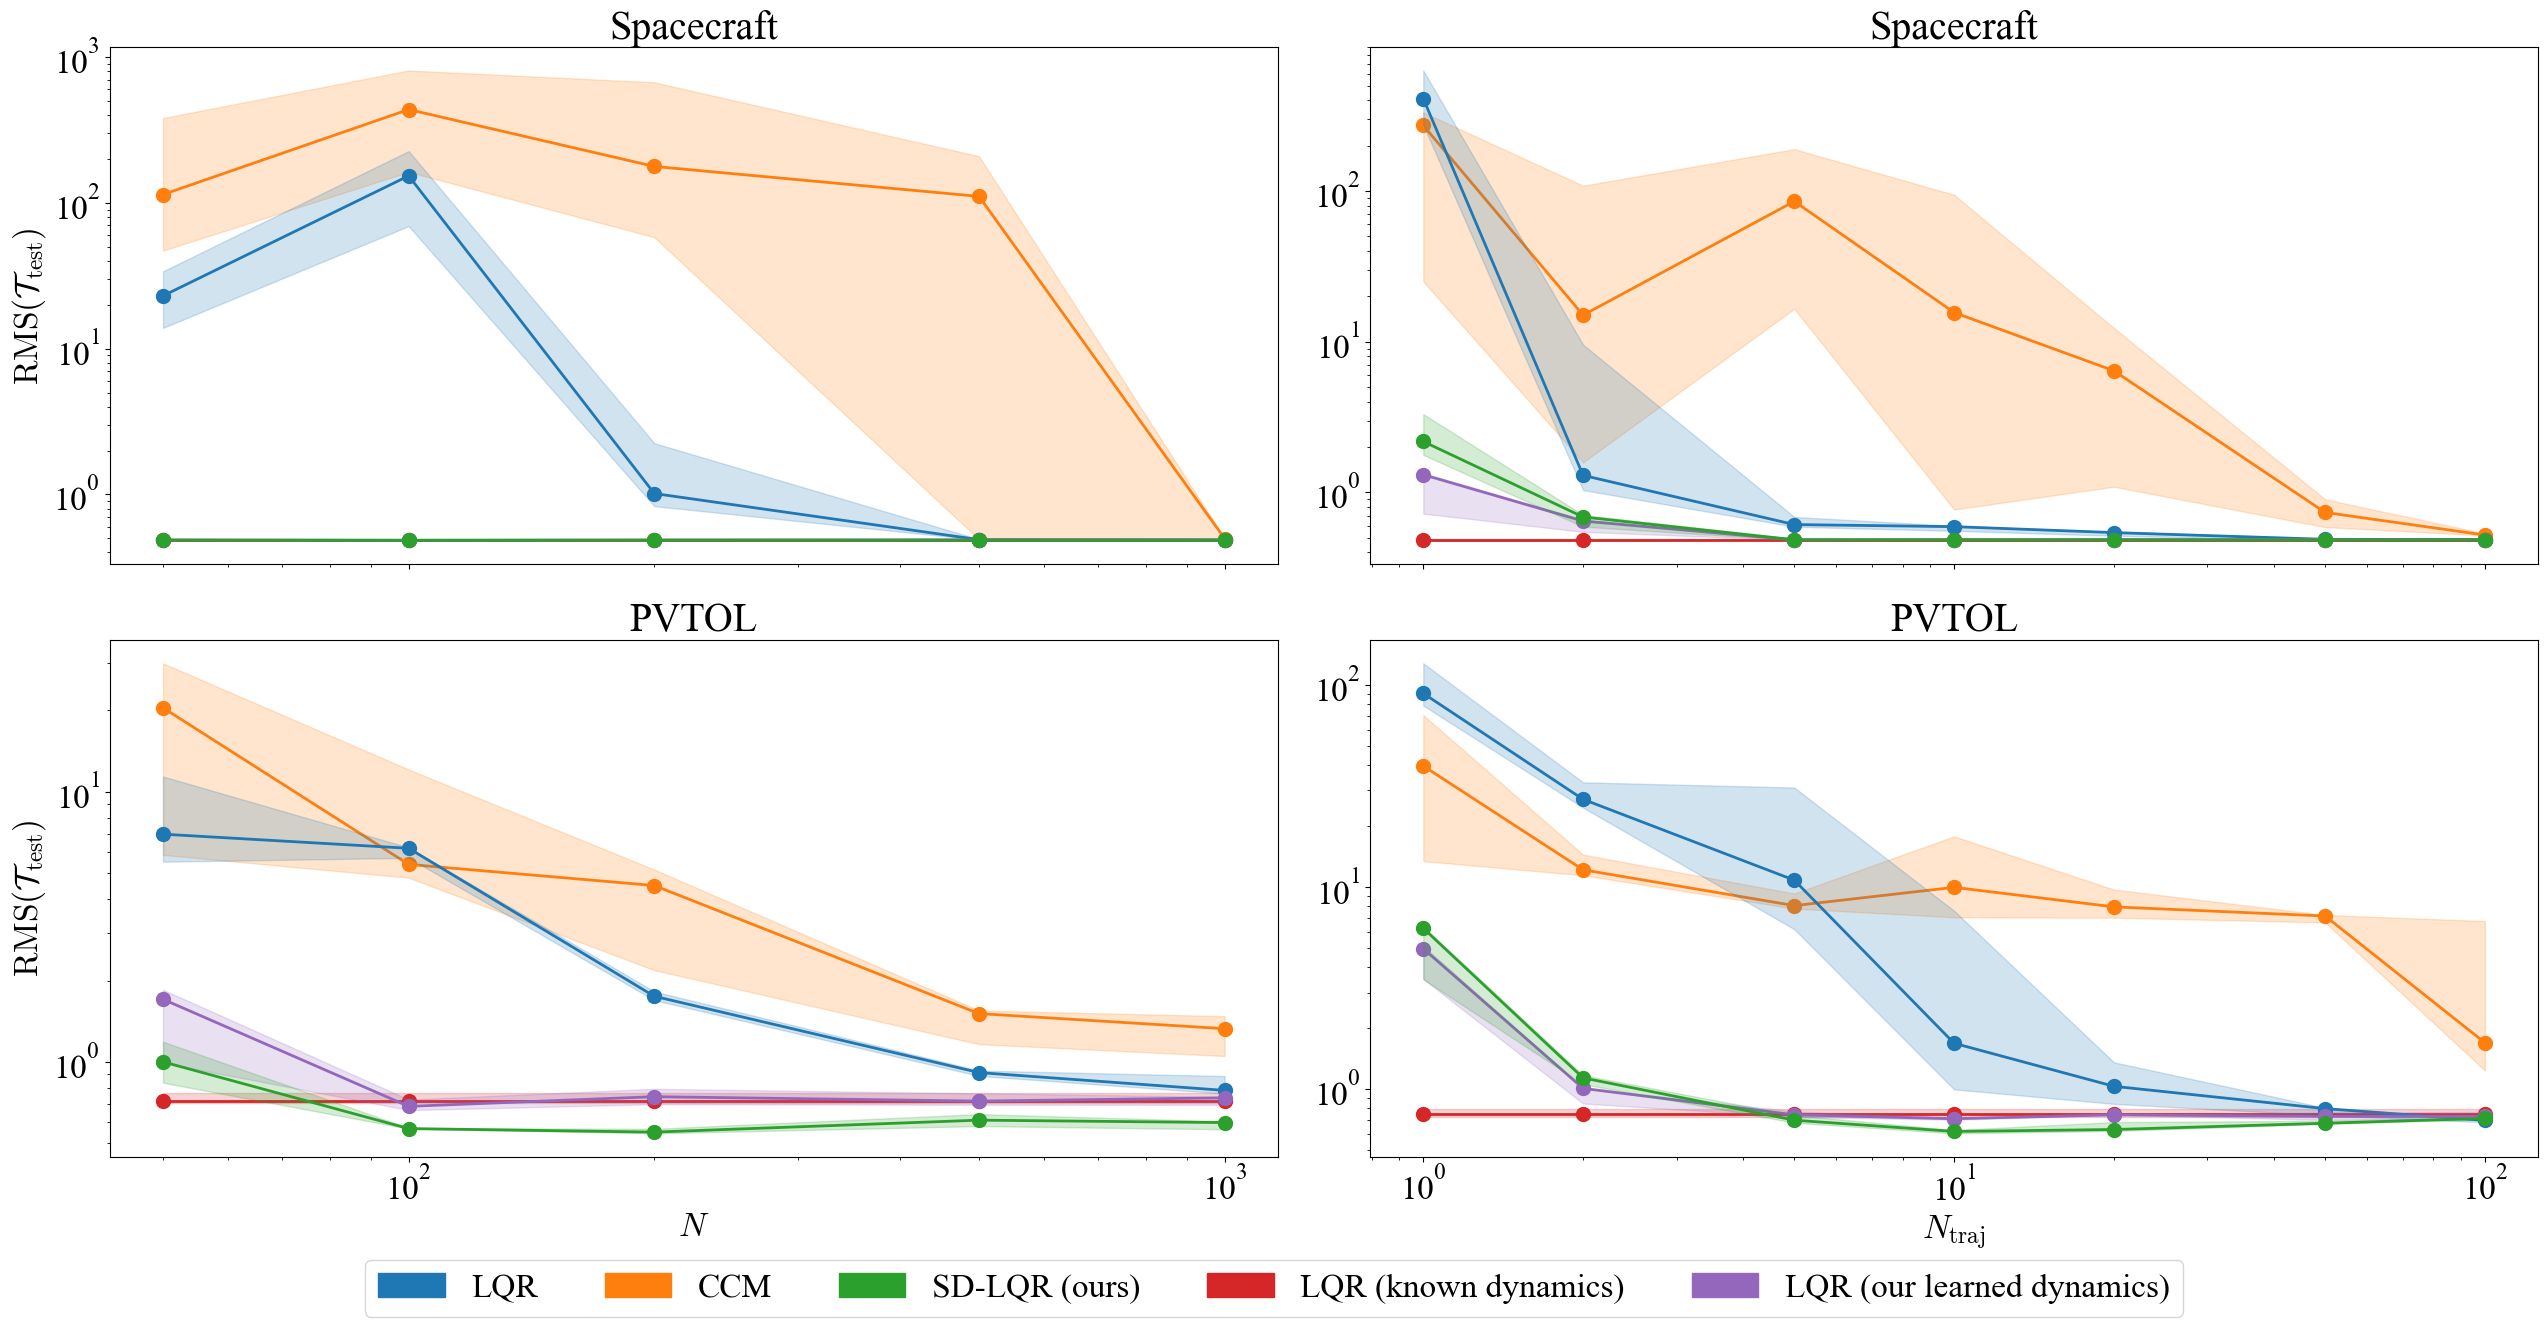

In [2]:
########################################################################################
# Plot error aggregated across test trajectories and random seeds
########################################################################################

fig, axes = plt.subplots(len(systems), 2, figsize=(2*ref_width, 1.7*ref_height), 
                         sharex='col')
axes = np.atleast_2d(axes)
alpha = 0.2

for (ax, filename_template, Ns, xlabel) in zip(
    [axes[:, 0], axes[:, 1]],
    [filename_template_unif, filename_template_traj],
    [Ns_unif, Ns_traj],
    [r'$N$', r'$N_\mathrm{traj}$'],
):
    ax[-1].set_xlabel(xlabel)

    for k, system in enumerate(systems):
        ax[k].set_title(titles[k])
        rmse = {ctrl: np.zeros((len(seeds), len(Ns))) for ctrl in controllers}

        for ctrl in controllers:
            for i, seed in enumerate(seeds):
                for j, N in enumerate(Ns):
                    # Load test results
                    filename = filename_template.format(seed, N)
                    path = os.path.join('test_results', system, ctrl, filename)
                    with open(path, 'rb') as file:
                        sims = dill.load(file)

                    # Compute normalized trajectory error over time
                    t, x, x_ref = sims['t'], sims['x'], sims['x_ref']
                    e_sq = np.sum((x - x_ref)**2, axis=-1)
                    e_sq /= e_sq[:, 0].reshape((-1, 1))

                    # Compute RMSE (averaged across all test trajectories)
                    rmse_all = np.sqrt(
                        scipy.integrate.trapezoid(e_sq, t, axis=-1) / t[-1]
                    )
                    rmse[ctrl][i, j] = np.mean(rmse_all)

        
        for ctrl, color, zorder in zip(controllers, colors, zorders):
            # Compute statistics
            mean, std = np.mean(rmse[ctrl], axis=0), np.std(rmse[ctrl], axis=0)
            q1, q2, q3 = np.quantile(rmse[ctrl], (0.25, 0.50, 0.75), axis=0)
            iqr = q3 - q1

            # Plot
            if log_scale:
                ax[k].loglog(Ns, q2, marker='o', color=color, zorder=zorder)
            else:
                ax[k].plot(Ns, q2, marker='o', color=color, zorder=zorder)
            if fill_whiskers:
                whisker_lo, whisker_hi = q1 - 1.5*iqr, q3 + 1.5*iqr
                ax[k].fill_between(Ns, whisker_lo, whisker_hi, 
                                color=color, alpha=alpha, zorder=zorder)
            else:
                ax[k].fill_between(Ns, q1, q3, color=color, alpha=alpha, zorder=zorder)

for a in axes[:, 0]:
    # a.set_ylabel(r'$\dfrac{1}{N_\mathrm{test}}\sum_{k=1}^{N_\mathrm{test}}\ '
    #              r'\sqrt{\dfrac{1}{T^{(k)}}\int_0^{T^{(k)}}\!\dfrac{'
    #              r'||e^{(k)}(t)||_2^2}{||e^{(k)}(0)||_2^2}\,dt}$')
    a.set_ylabel(r'$\mathrm{RMS}(\mathcal{T}_\mathrm{test})$')

fig.legend(**legend_kwargs)
fig.tight_layout()
fig.subplots_adjust(bottom=0.13)

path = os.path.join(directory, 'efficiency')
fig.savefig(path, bbox_inches='tight')
plt.show()

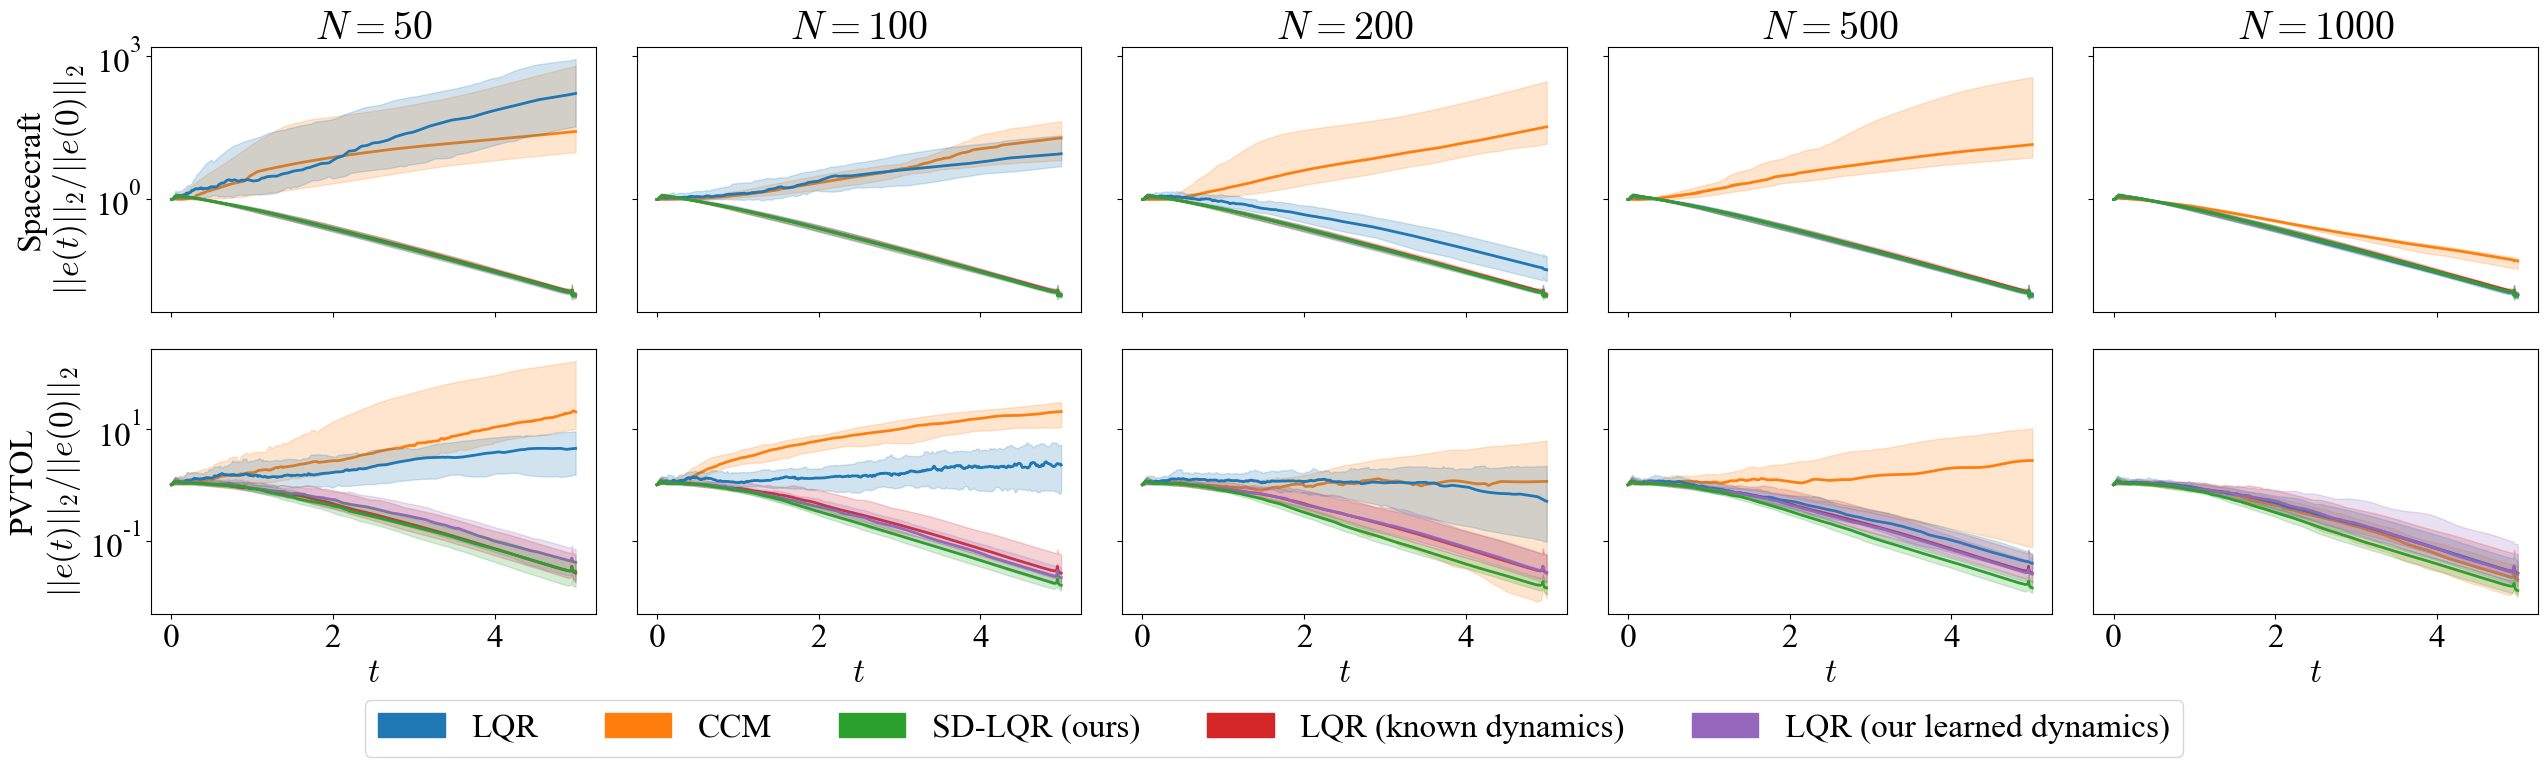

In [3]:
########################################################################################
# Plot all trajectories for a single seed
########################################################################################
seeds_sys = [0, 4, 2]  # for each system
fig, ax = plt.subplots(len(systems), len(Ns_unif), 
                       figsize=(2*ref_width, ref_height),
                       sharex=True, sharey='row')
ax = np.atleast_1d(ax)
for a in ax[-1, :]:
    a.set_xlabel(r'$t$')
for a, N in zip(ax[0, :], Ns_unif):
    a.set_title(r'$N = {}$'.format(N))

for ctrl, color, zorder in zip(controllers, colors, zorders):
    for i, (system, title, seed) in enumerate(zip(systems, titles, seeds_sys)):
        for j, N in enumerate(Ns_unif):
            # Load test results
            filename = filename_template_unif.format(seed, N)
            path = os.path.join('test_results', system, ctrl, filename)
            with open(path, 'rb') as file:
                sims = dill.load(file)

            # Compute normalized trajectory error over time
            t, x, x_ref = sims['t'], sims['x'], sims['x_ref']
            errors = np.linalg.norm(x - x_ref, axis=-1)
            errors /= errors[:, 0].reshape((-1, 1))

            # Compute statistics
            mean, std = np.mean(errors, axis=0), np.std(errors, axis=0)
            q1, q2, q3 = np.quantile(errors, (0.25, 0.50, 0.75), axis=0)
            iqr = q3 - q1
            whisker_lo, whisker_hi = q1 - 1.5*iqr, q3 + 1.5*iqr

            # Plot
            if log_scale:
                ax[i, j].semilogy(t, q2, color=color, zorder=zorder)
            else:
                ax[i, j].plot(t, q2, color=color, zorder=zorder)
            if fill_whiskers:
                ax[i, j].fill_between(t, whisker_lo, whisker_hi, 
                                      color=color, alpha=alpha, zorder=zorder)
            else:
                ax[i, j].fill_between(t, q1, q3, color=color, alpha=alpha, 
                                      zorder=zorder)
        ax[i, 0].set_ylabel(title + '\n' + r'$||e(t)||_2 / ||e(0)||_2$')

fig.legend(**legend_kwargs)
fig.tight_layout()
fig.subplots_adjust(bottom=0.2)
fig.savefig(os.path.join(directory, 'trends'), bbox_inches='tight')
plt.show()

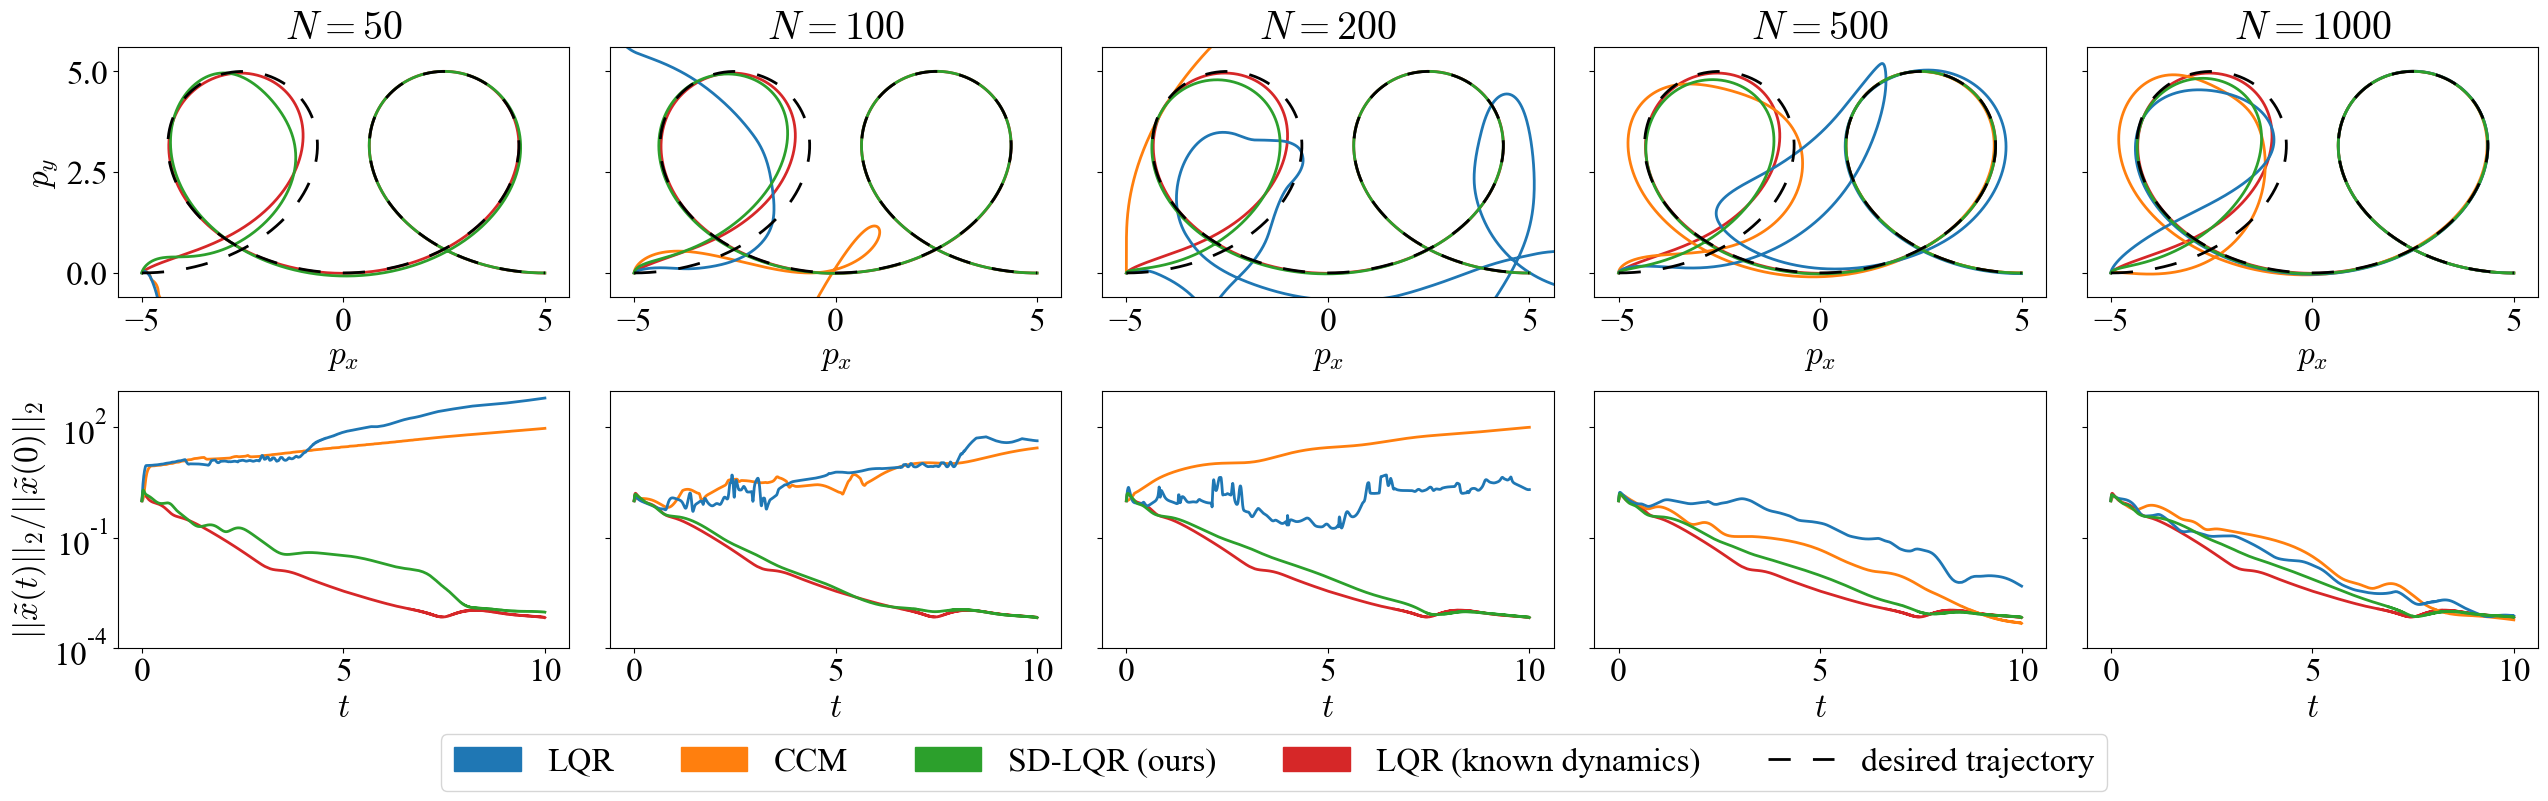

In [4]:
########################################################################################
# Plot double-loop trajectory for the PVTOL (PlanarBirotor)
########################################################################################

seed = 0
filename_template = 'seed={}_N={}.dill'

fig, ax = plt.subplots(2, len(Ns_unif), figsize=(2*ref_width, ref_height), sharex='row',
                       sharey='row')
ax = np.atleast_2d(ax)

# Axes formatting
pad = 0.6
ax[0, 0].set_ylabel(r'$p_y$')
for a in ax[0, :]:
    a.set_xlabel(r'$p_x$')
# ax[1, 0].set_ylabel(r'$||e(t)||_2 / ||e(0)||_2$')
ax[1, 0].set_ylabel(r'$||\tilde{x}(t)||_2 / ||\tilde{x}(0)||_2$')
for a in ax[1, :]:
    a.set_xlabel(r'$t$')
for a, N in zip(ax[0, :], Ns_unif):
    a.set_title(r'$N = {}$'.format(N))
for a in ax[0, :]:
    a.set_xlim(-5. - pad, 5. + pad)
    a.set_ylim(-pad, 5. + pad)
    a.set_aspect('equal')
for a in ax[1, :]:
    a.set_yscale('log')
    a.set_xlim(-pad, 10. + pad)
    a.set_ylim(1e-4, 1e3)

# Legend formatting
ls_ref = (0, (8, 8))
legend_kwargs_with_ref = {
    'handles':          patches[:-1],
    'loc':              'lower center', 
    'ncol':             len(labels[:-1]), 
    'bbox_to_anchor':   (0.5, 0.),
}
legend_kwargs_with_ref['handles'].append(Line2D([0], [0], color='k', ls=ls_ref, 
                                                label='desired trajectory'))
legend_kwargs_with_ref['ncol'] += 1
fig.legend(**legend_kwargs_with_ref)
fig.tight_layout()
fig.subplots_adjust(hspace=0.35, bottom=0.2)

# Plot double-loop reference trajectory
filename = filename_template.format(seed, Ns_unif[0])
path = os.path.join('test_results', 'PlanarBirotor_DoubleLoop', 
                    controllers[0], filename)
with open(path, 'rb') as file:
    x_ref = dill.load(file)['x_ref']
for a in ax[0, :]:
    a.plot(x_ref[:, 0], x_ref[:, 1], color='k', ls=ls_ref, zorder=100)
fig.savefig(os.path.join(directory, 'double_loop_0'), bbox_inches='tight')

# Plot trajectories
idx = [3, 0, 1, 2]
for k, (ctrl, color, zorder) in enumerate(zip([controllers[i] for i in idx],
                                              [colors[i] for i in idx],
                                              [zorders[i] for i in idx])):
    for j, N in enumerate(Ns_unif):
        # Load test results
        filename = filename_template.format(seed, N)
        path = os.path.join('test_results', 'PlanarBirotor_DoubleLoop', ctrl, 
                            filename)
        with open(path, 'rb') as file:
            sims = dill.load(file)

        # Compute normalized trajectory error over time
        t, x, x_ref = sims['t'], sims['x'], sims['x_ref']
        error = np.linalg.norm(x - x_ref, axis=-1)
        error /= error[0]

        # Plot
        ax[0, j].plot(x[:, 0], x[:, 1], color=color, zorder=zorder)
        if log_scale:
            ax[1, j].semilogy(t, error, color=color, zorder=zorder)
        else:
            ax[1, j].plot(t, error, color=color, zorder=zorder)

    # Save figure
    fig.savefig(os.path.join(directory, 'double_loop_' + str(k+1)), bbox_inches='tight')

plt.show()